This notebook generaters synthetic building data sets that can be used to develop and test end-use load decomposition methods.

# Preparation

The following verifies that the host system is prepared for this notebook.

## GridLAB-D

We recommend using GridLAB-D Version 4.2 or later.

In [1]:
!gridlabd --version='-ge 4.2'

## Time
The time window of the simulation must be specified. We have chosen to use 2021 for an annual simulation.

In [2]:
!cat time.glm

clock
{
	timezone "PST+8PDT";
	starttime "2021-01-01 00:00:00 PST";
	stoptime "2022-01-01 00:00:00 PST";
}

## Weather
The weather data must also be downloaded for the test case.

In [3]:
!cat weather.glm

#weather get "CO-Denver_Intl_Ap.tmy3"
#input "CO-Denver_Intl_Ap.tmy3"


## Residential
The residential module is used to model homes, and uses the following settings to enable the data-drive end-use loads for the dishwasher, clotheswasher, dryer, waterheater, refrigerator, range, lights, and plugs.

In [4]:
!cat residential.glm

module residential
{
	implicit_enduses DISHWASHER|CLOTHESWASHER|DRYER|WATERHEATER|REFRIGERATOR|RANGE|LIGHTS|PLUGS;
}

## Recording
The data collection process uses the `tape` module's `recorder` object to collect power and energy data from the house's electrical panel. The `interval -1` indicates that a sample is taken anytime one of the values changes.

In [5]:
!cat recording.glm

module tape
{
	csv_header_type NAME;
}
#set dateformat=ISO8601
#set complex_format="%+.6f%+.6fj"


# Single Home

The single home model is a medium-size home in California, defined as follows

In [6]:
!cat house.glm

#include "time.glm"
#include "weather.glm"
#include "residential.glm"
#include "recording.glm"
#set show_progress=FALSE
object house
{
	floor_area 2500 sf;
	object recorder
	{
		property "panel.power";
		file "house.csv";
		interval -1;
	};
}

Now we can run the simulation.

In [7]:
!gridlabd house.glm

WARNING [INIT] : house:1: house_e:1 has no parent triplex_meter defined; using static voltages


The voltage warning is ok for now.  The instantaneous power is sampled whenever the power changes. This can occur at any time and results in irregular sampling intervals, which can be difficult to work with.

In [8]:
import pandas, datetime, numpy
def to_timestamp(s):
    return datetime.datetime.fromisoformat(s)
def to_real(s):
    return complex(s).real

<AxesSubplot:title={'center':'Instantaneous power'}, xlabel='timestamp', ylabel='kW'>

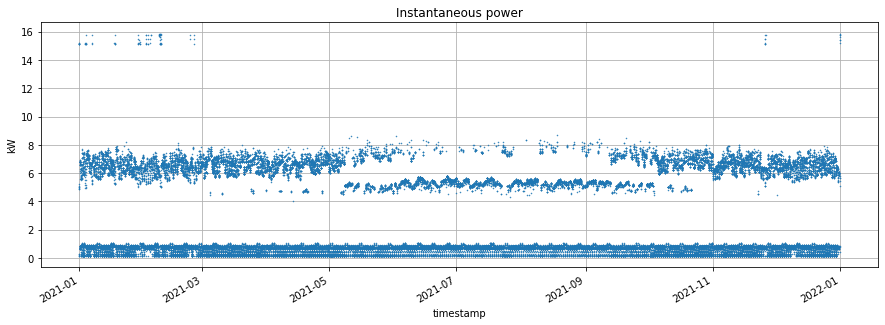

In [9]:
panel = pandas.read_csv('house_1.csv',
                        header = 0,
                        names = ['timestamp','power'],
                        converters = {
                            'timestamp':to_timestamp,
                            'power':to_real},
                        index_col='timestamp')
panel['power'].plot(style='.',markersize=1,figsize=(15,5),ylabel='kW',grid=True,title='Instantaneous power')

# Metering
The solution to irregular sampling is to measure the total cumulative energy use at regular intervals, e.g., 15 minutes, and take the difference with the previous observation.  This is what meter objects do, as illustrated in the following model:

In [10]:
!cat meter.glm

#include "time.glm"
#include "weather.glm"
#include "recording.glm"
#include "residential.glm"
#set show_progress=FALSE
module powerflow;
object triplex_meter
{
	phases AS;
	nominal_voltage 120;
	measured_energy_delta_timestep 900;
	object house
	{
		floor_area 2500 sf;
	};
	object recorder
	{
		property "measured_real_energy_delta";
		file "meter.csv";
		interval 900;		
	};
}


In [11]:
!gridlabd meter.glm

<AxesSubplot:title={'center':'Periodic demand'}, xlabel='timestamp', ylabel='kW'>

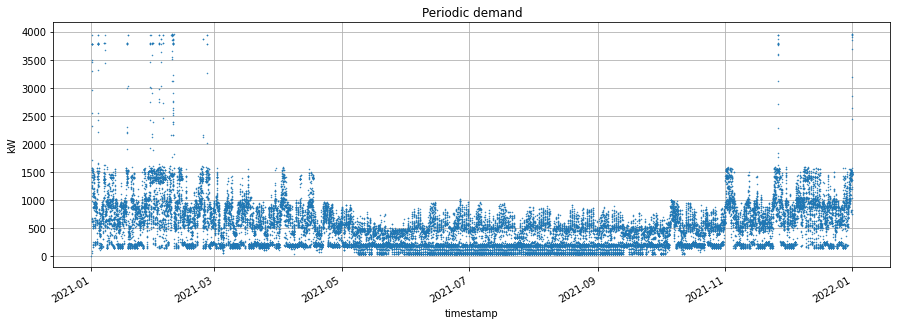

In [12]:
panel = pandas.read_csv('meter.csv',
                        header = 0,
                        names = ['timestamp','power'],
                        converters = {
                            'timestamp':to_timestamp,
                            'power':to_real},
                        index_col='timestamp')
panel['power'].plot(style='.',markersize=1,figsize=(15,5),ylabel='kW',grid=True,title='Periodic demand')

# Service Transformer
Typically more than one house is served by a single service transformer.  The following model provide the observed load for 4 homes on a single service transformer sampled at 1 minute intervals.

In [13]:
!cat transformer.glm

clock
{
	timezone "PST+8PDT";
	starttime "2021-01-01 00:00:00 PST";
	stoptime "2021-01-08 00:00:00 PST";
}
#include "weather.glm"
#include "recording.glm"
#include "residential.glm"
#set show_progress=FALSE
module powerflow;
object triplex_meter
{
	phases AS;
	nominal_voltage 120;
	measured_energy_delta_timestep 60;
	object house:..4
	{
		floor_area random.triangle(1000,3000);
	};
	object recorder
	{
		property "measured_real_energy_delta";
		file "transformer.csv";
		interval 60;		
	};
}


In [14]:
!gridlabd transformer.glm

<AxesSubplot:title={'center':'Service transformer load'}, xlabel='timestamp', ylabel='kW'>

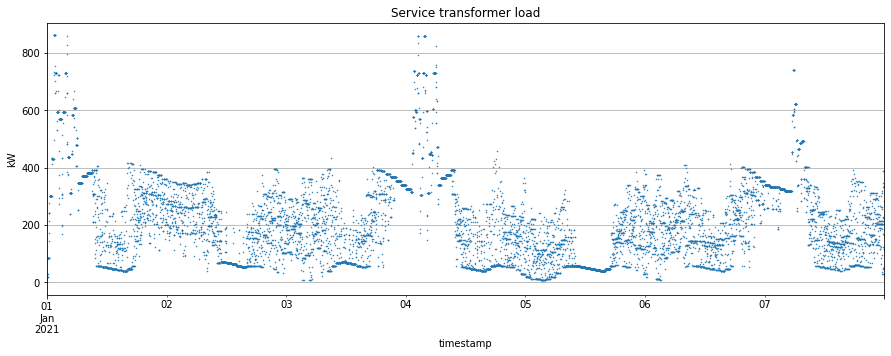

In [15]:
panel = pandas.read_csv('transformer.csv',
                        header = 0,
                        names = ['timestamp','power'],
                        converters = {
                            'timestamp':to_timestamp,
                            'power':to_real},
                        index_col='timestamp')
panel['power'].plot(style='.',markersize=1,figsize=(15,5),ylabel='kW',grid=True,title='Service transformer load')

# Feeder
At the feeder level, the total load could include several hundred homes, as illustrated by the following model. Note that the model does not include line losses between the feeder and the homes. Also, because the number of homes is so large, the annual simulation takes longer, so the time horizon is shortened to a week. 

In [16]:
!cat feeder.glm

clock
{
	timezone "PST+8PDT";
	starttime "2021-01-01 00:00:00 PST";
	stoptime "2021-01-08 00:00:00 PST";
}
#include "weather.glm"
#include "recording.glm"
#include "residential.glm"
#set show_progress=FALSE
module powerflow;
object triplex_meter
{
	phases AS;
	nominal_voltage 120;
	measured_energy_delta_timestep 60;
	object house:..50
	{
		floor_area random.triangle(1000,3000);
	};
	object recorder
	{
		property "measured_real_energy_delta";
		file "feeder.csv";
		interval 60;		
	};
}


In [17]:
!gridlabd feeder.glm

<AxesSubplot:title={'center':'Feeder load'}, xlabel='timestamp', ylabel='kW'>

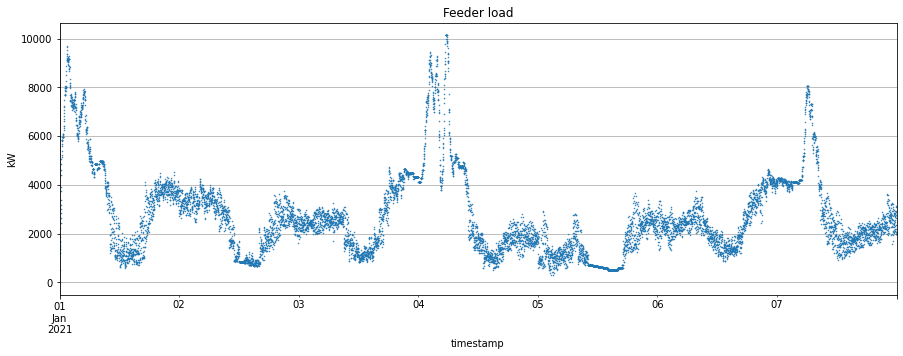

In [18]:
panel = pandas.read_csv('feeder.csv',
                        header = 0,
                        names = ['timestamp','power'],
                        converters = {
                            'timestamp':to_timestamp,
                            'power':to_real},
                        index_col='timestamp')
panel['power'].plot(style='.',markersize=1,figsize=(15,5),ylabel='kW',grid=True,title='Feeder load')